In [133]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, Normalize

import seaborn as sns


In [134]:
df_countries_codes = pd.read_csv('../environnement_data/countries_codes_and_coordinates.csv')
df_countries_codes = df_countries_codes.rename(columns = {'Alpha-3 code':'iso_a3'})
df_countries_codes['iso_a3'] = df_countries_codes['iso_a3'].apply(lambda x: x.replace('"', ''))
df_countries_codes['iso_a3'] = df_countries_codes['iso_a3'].apply(lambda x: x.replace(' ', ''))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data = pd.read_csv('../environnement_data/ENS - Cultural Index - Countries Databases - consolidate_table.csv')
data = data[['region', 'region_code', 'iso_a3',  'min_date', 'max_date']].copy()


data['max_date'] = round(data['max_date'], 0)
data['max_date'][data['max_date']==1900] = 1850

#data = data[data['region']=='Greek World']
data = data.sort_values(['min_date', 'max_date'], ascending=(True, True))
data = data.reset_index(drop=True)

df_country_names = world[['name', 'iso_a3']].drop_duplicates().copy()
data = pd.merge(data, df_country_names, on = 'iso_a3')


# Group by iso_a3 and aggregate min and max dates
data = data.groupby(['region', 'region_code', 'iso_a3']).agg({'min_date': 'min', 'max_date': 'max'}).reset_index()
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1500)] = 700
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1850)] = 700
data['max_date'][(data['region']=='Greek World')&(data['max_date']==1400)] = 700
gdf = gpd.GeoDataFrame(data)


/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_2327/2892289647.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_2327/2892289647.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['max_date'][data['max_date']==1900] = 1850
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_2327/2892289647.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

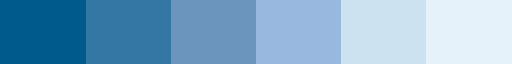

In [135]:

# Create a discrete colormap with shades of blue based on time
cmap = ListedColormap(['#005A8C', '#3477A5', '#6B95BD', '#99B8E0', '#CCE2F0', '#E6F2FA'])
cmap

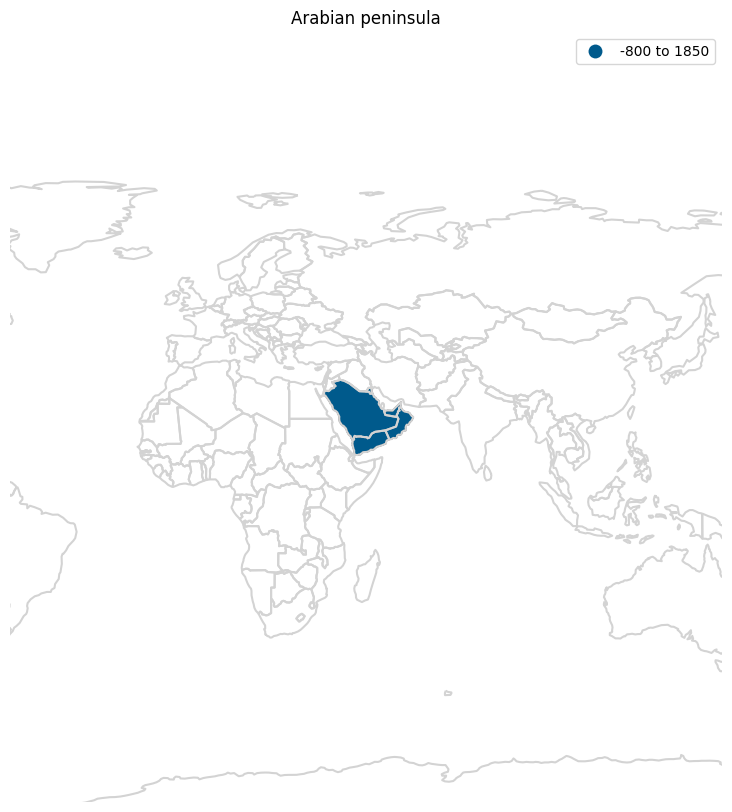

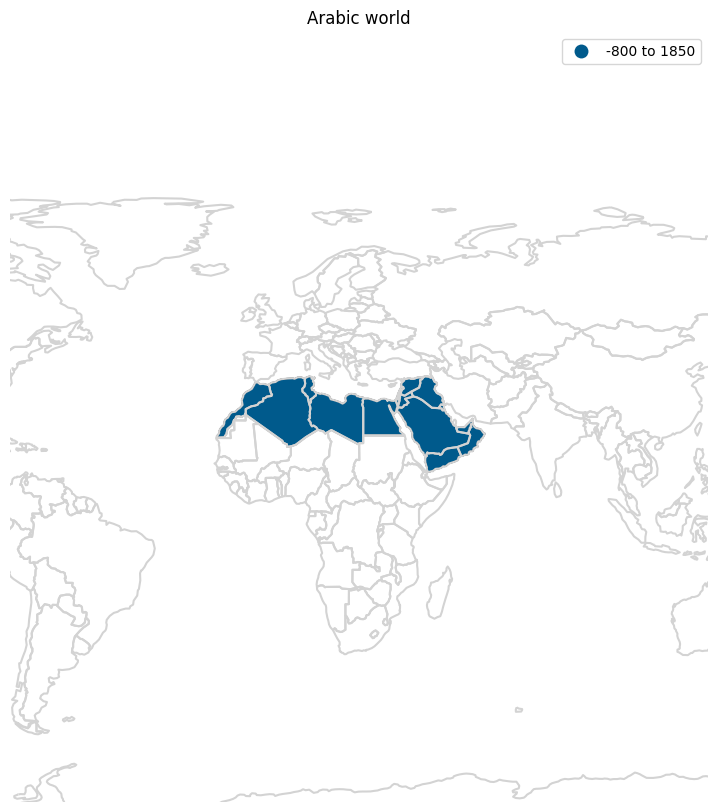

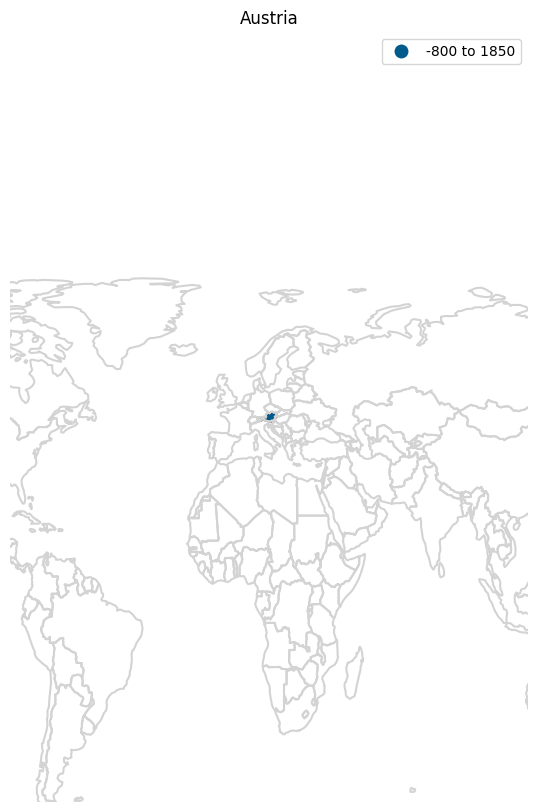

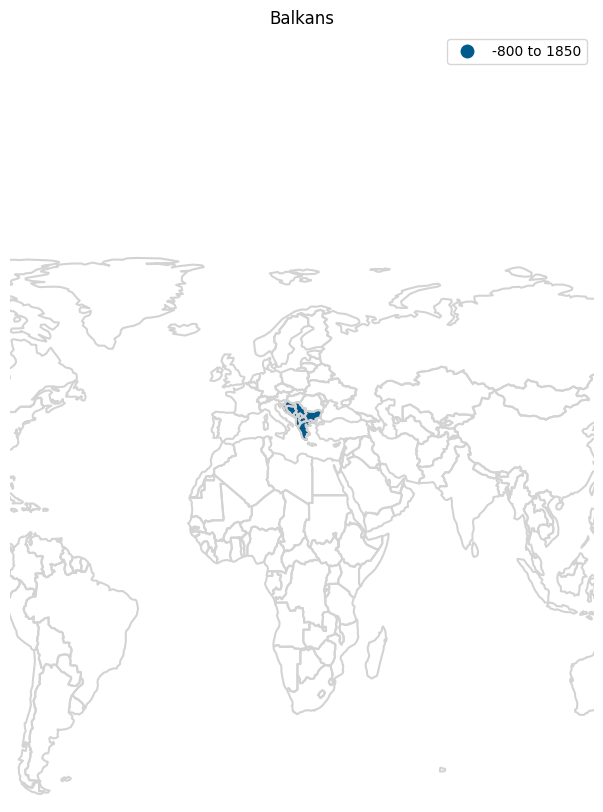

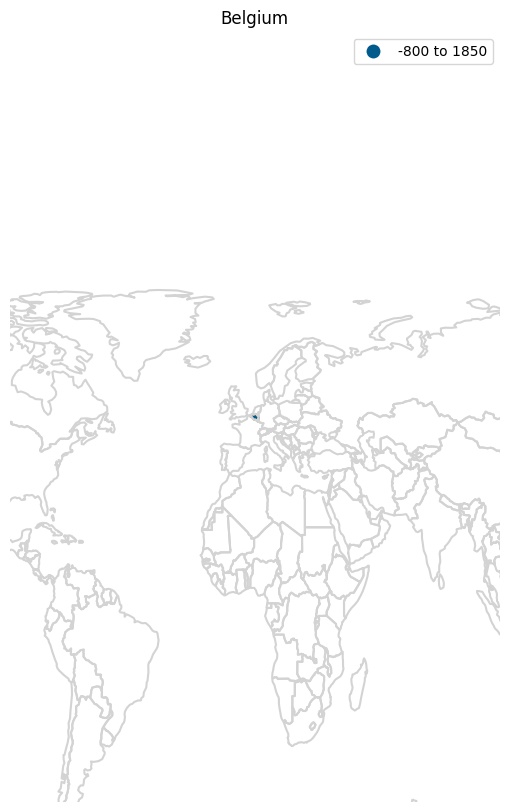

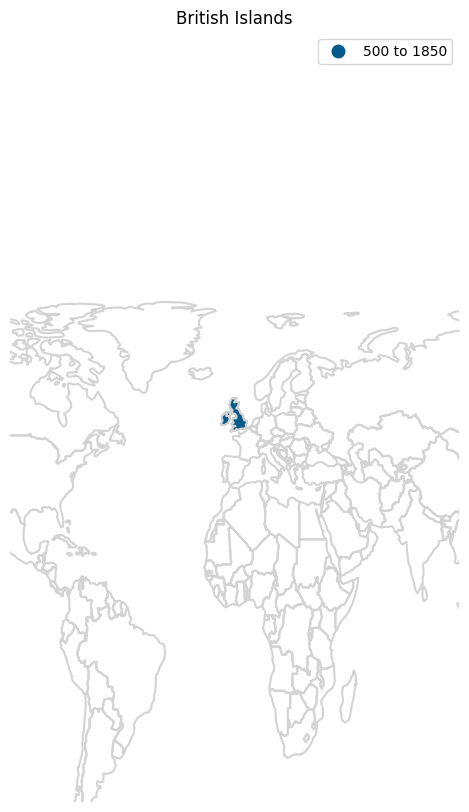

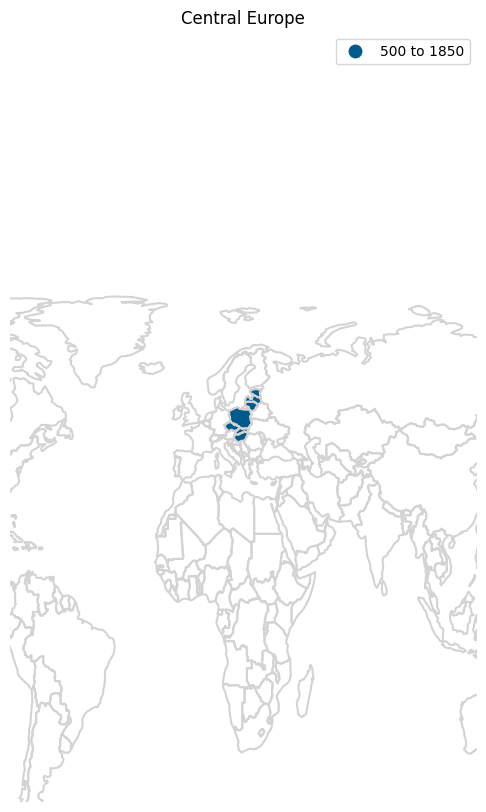

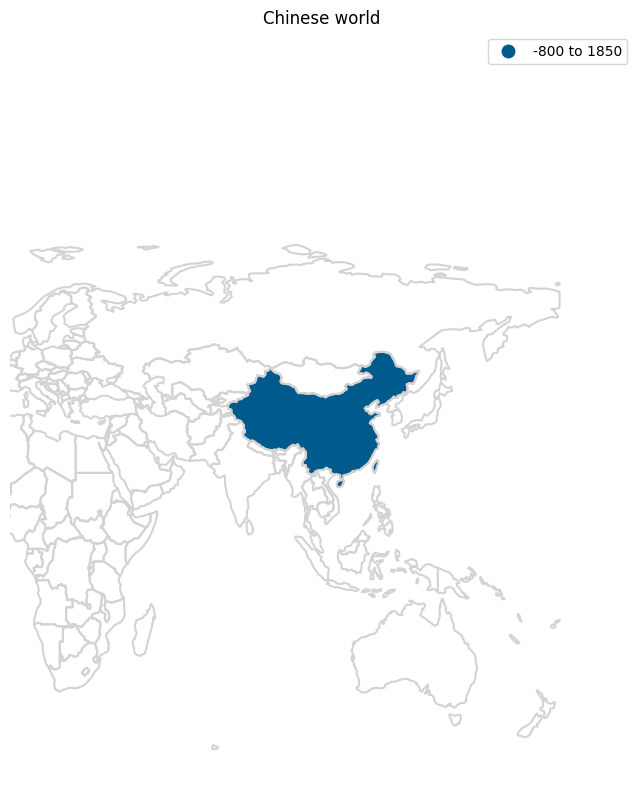

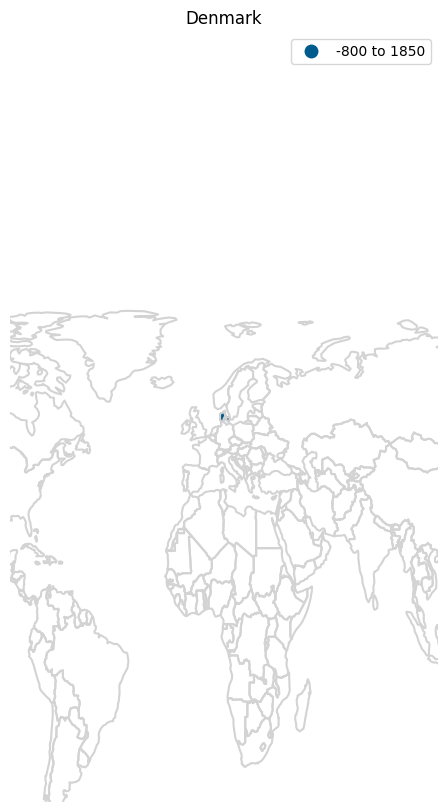

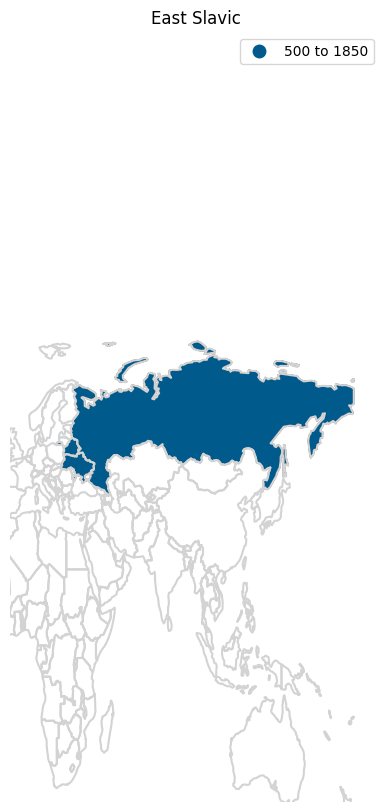

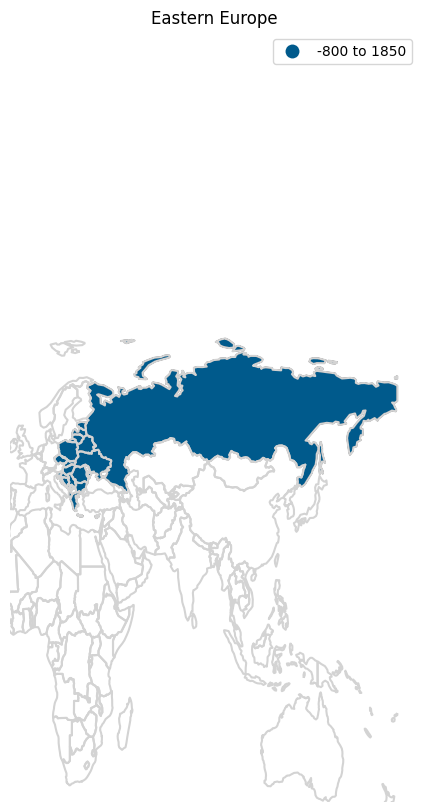

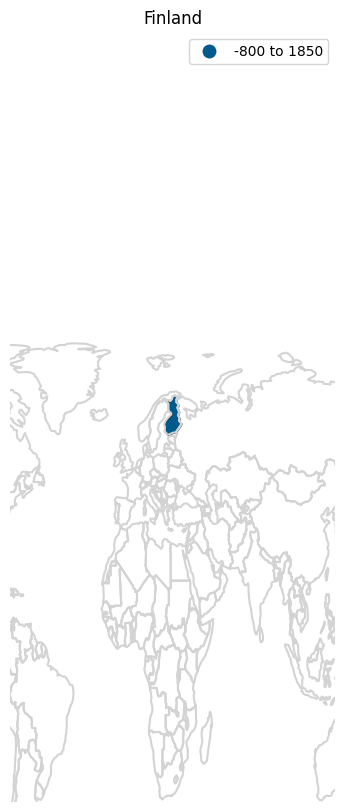

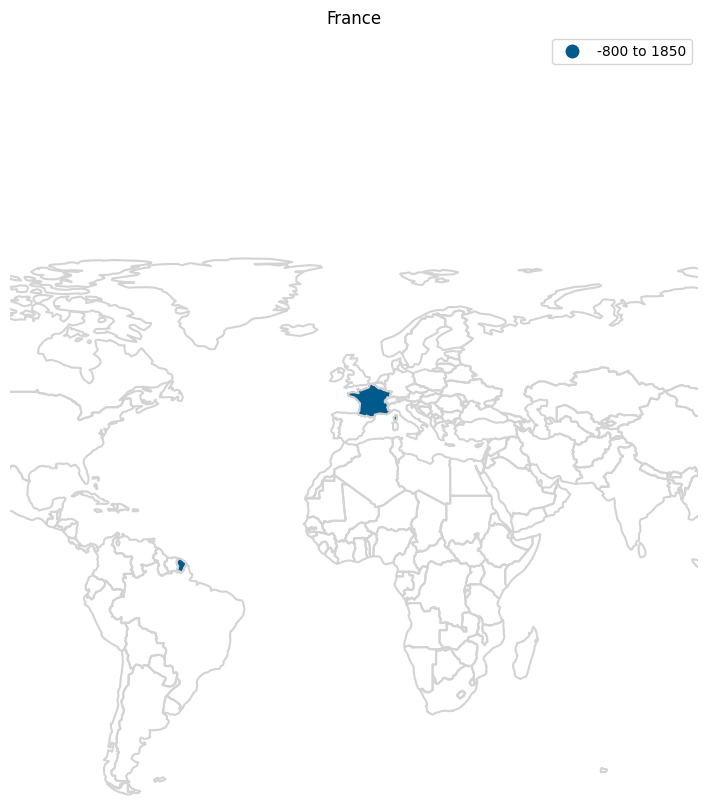

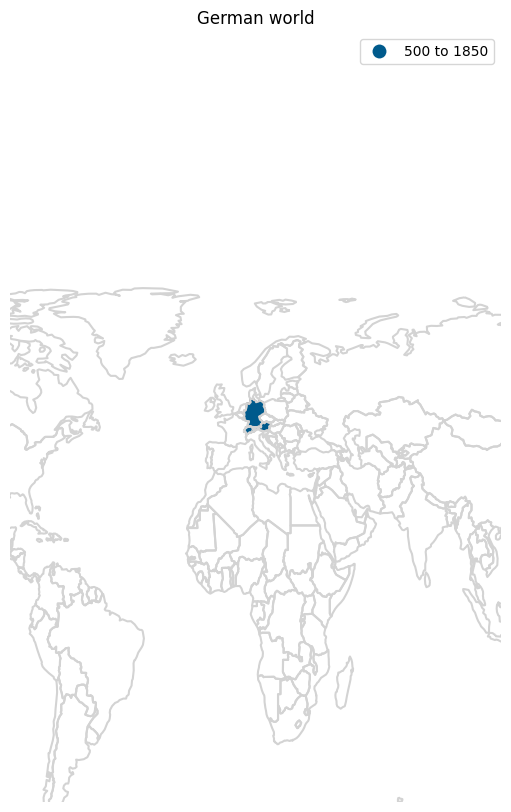

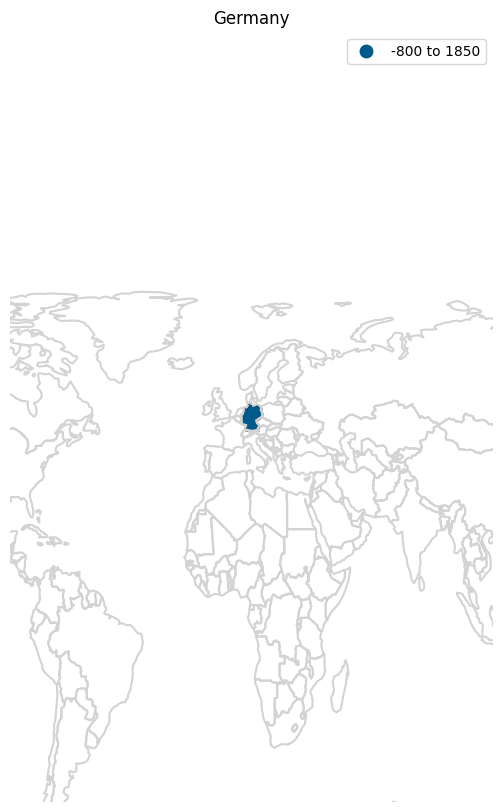

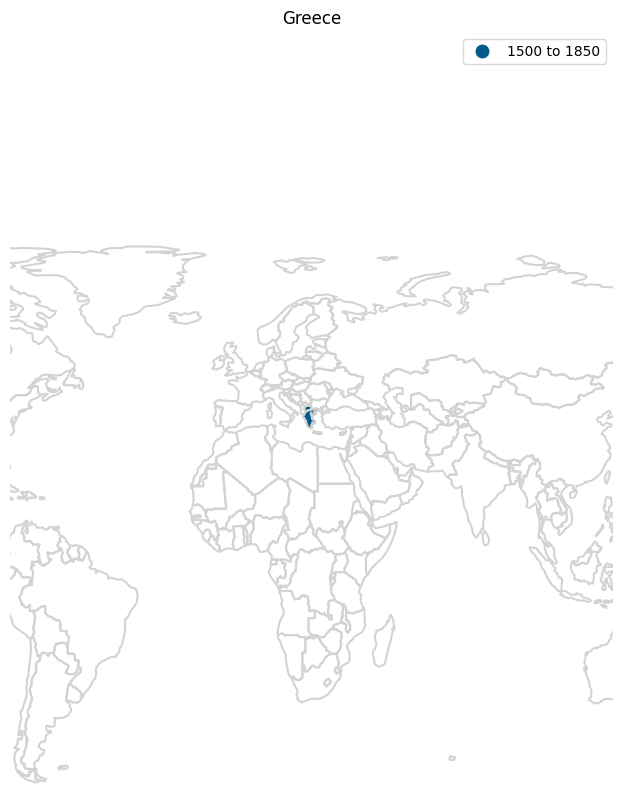

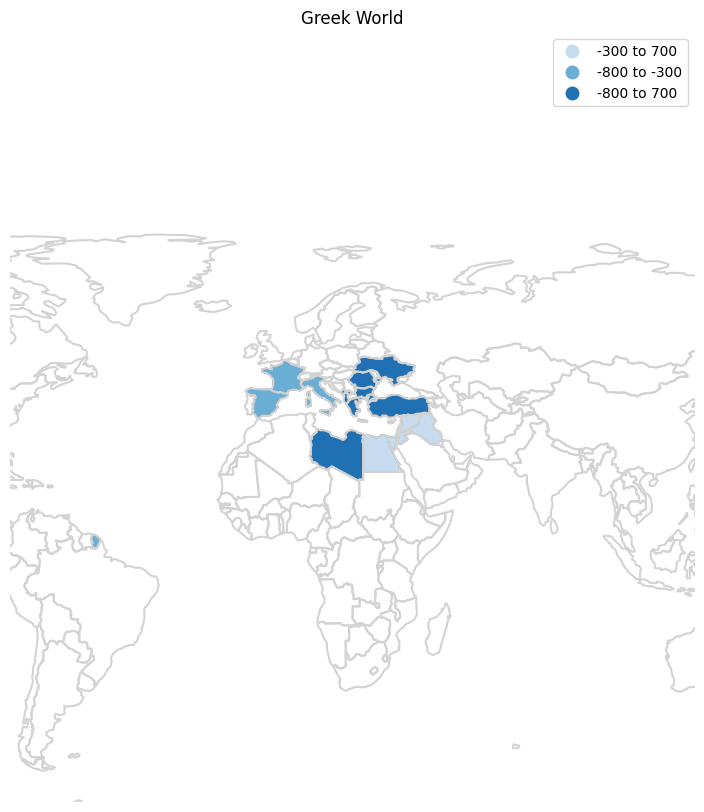

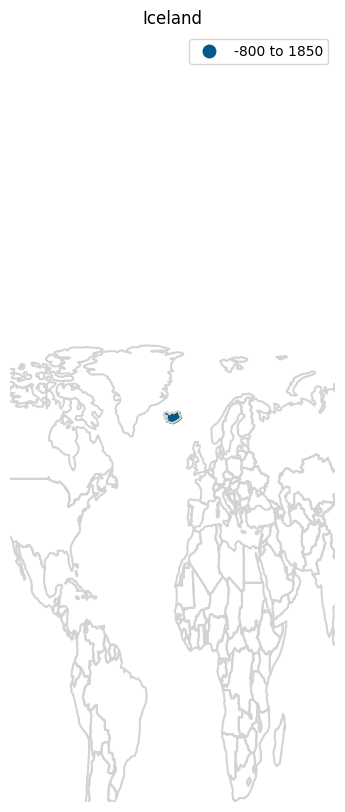

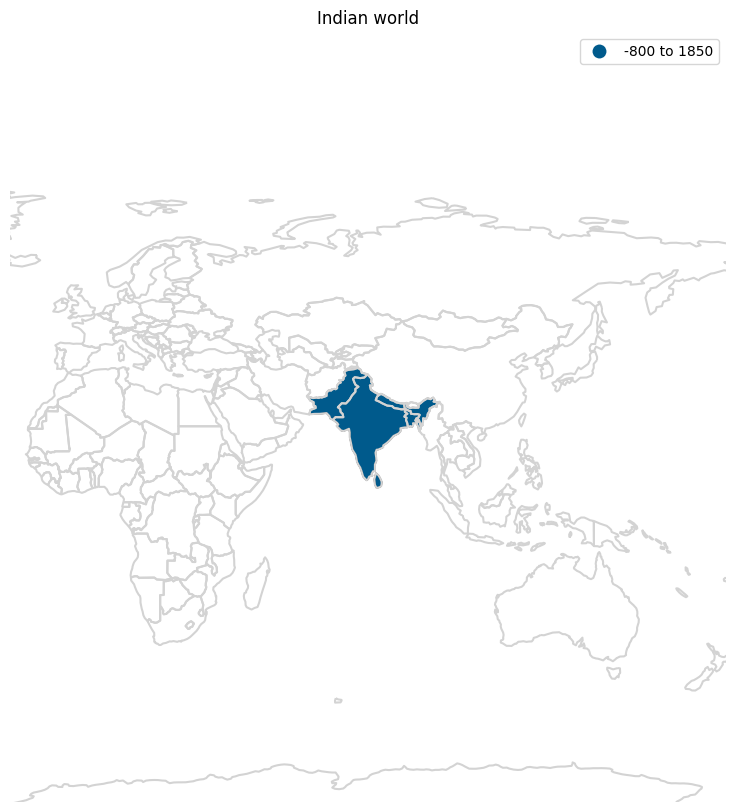

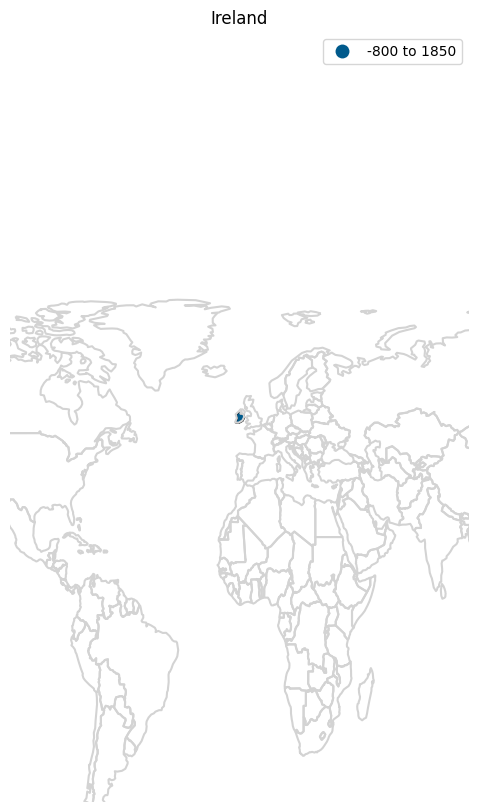

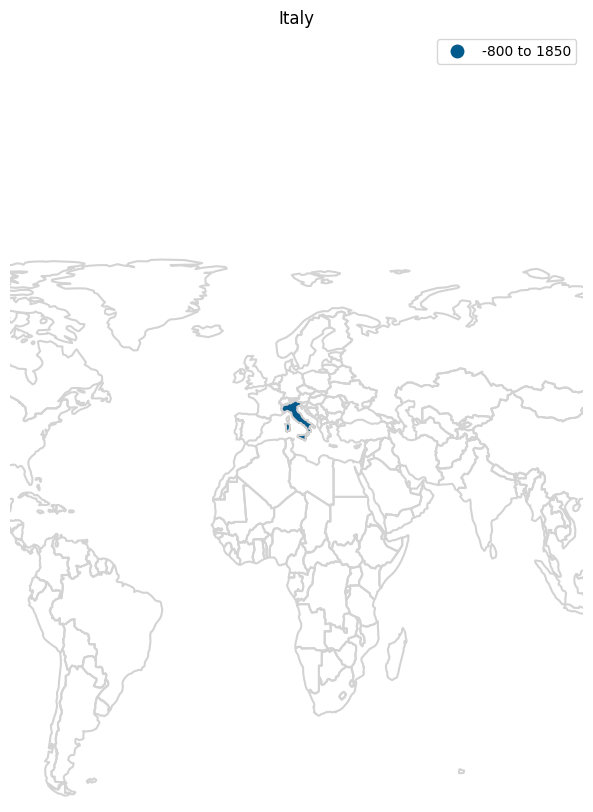

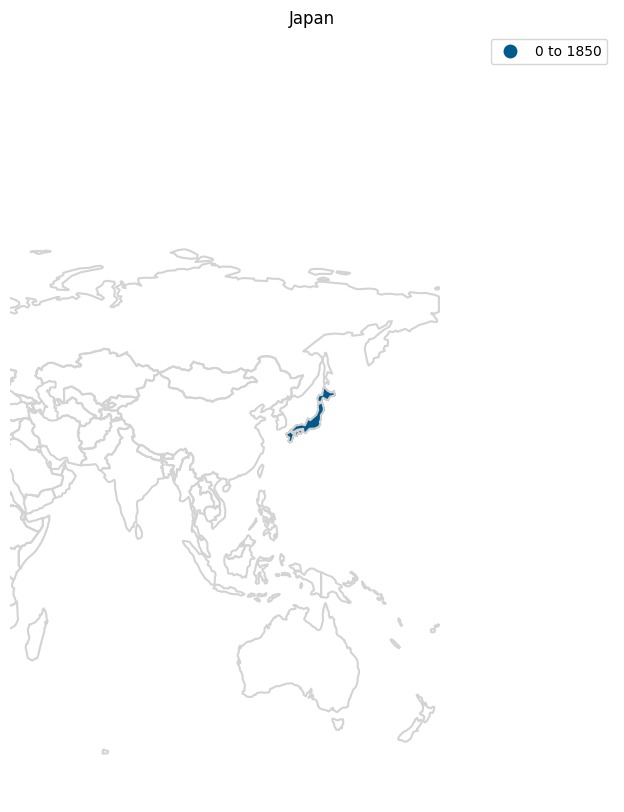

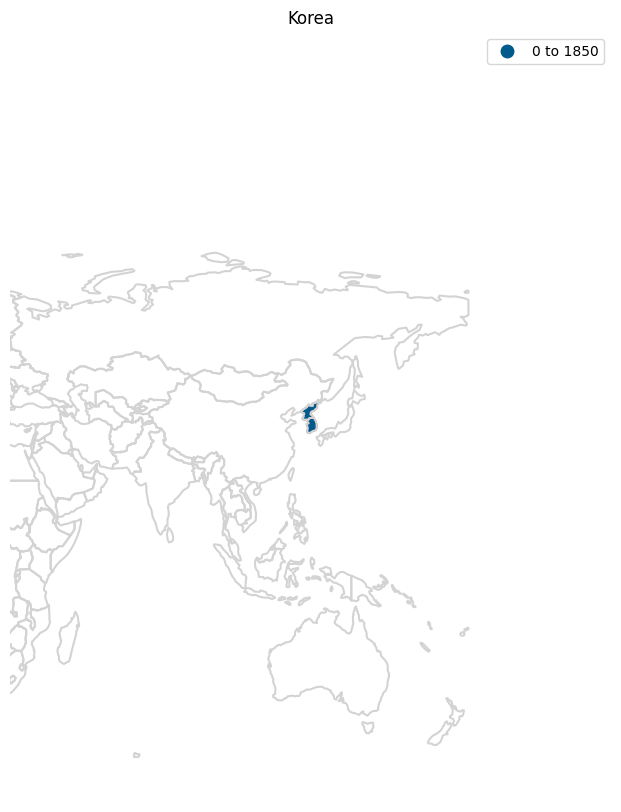

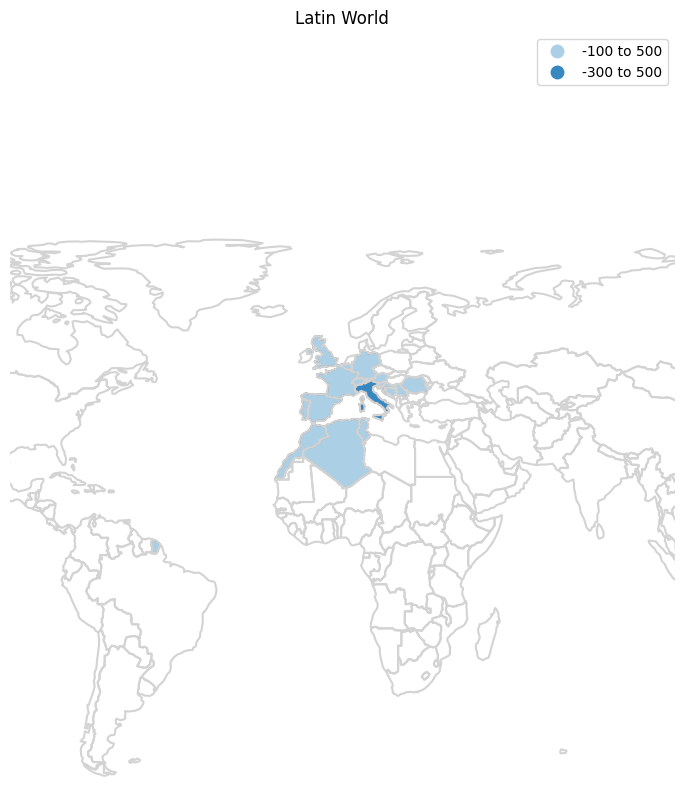

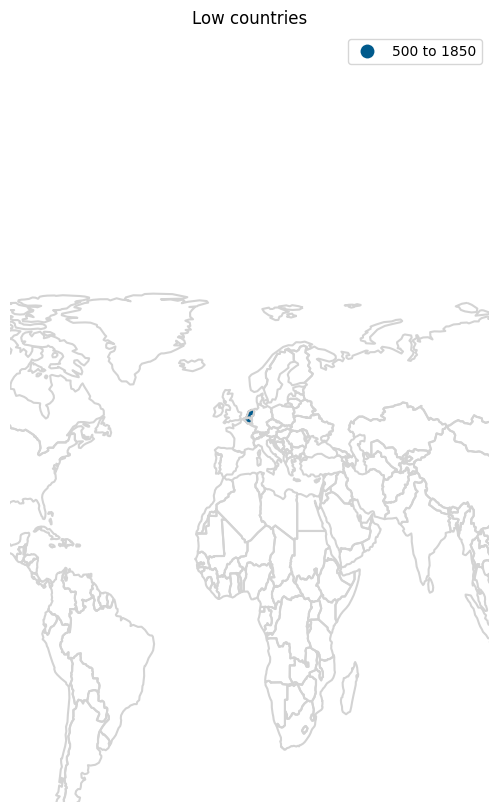

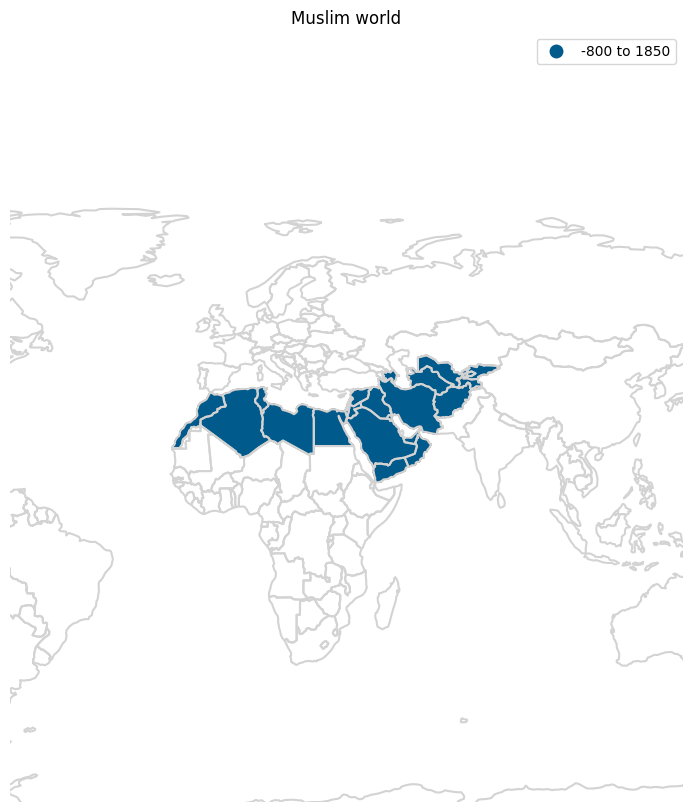

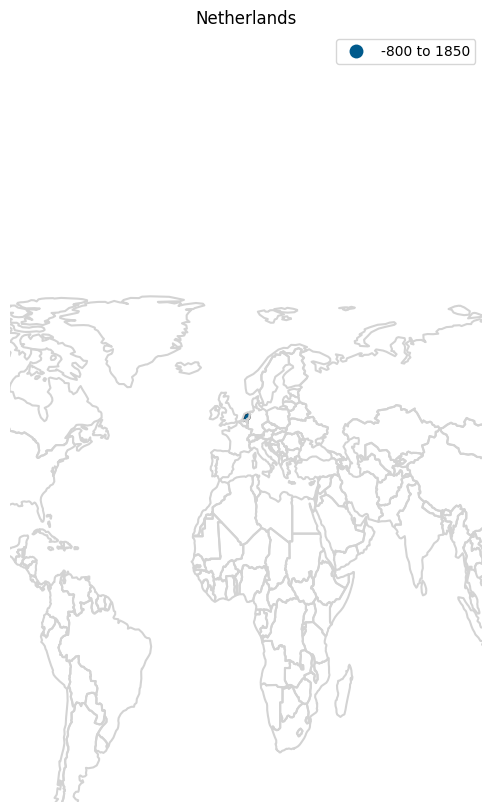

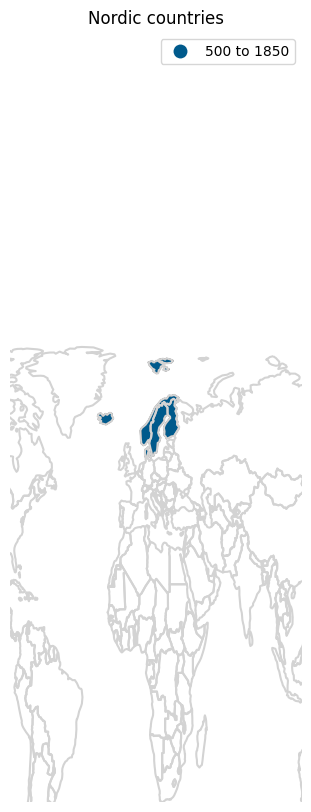

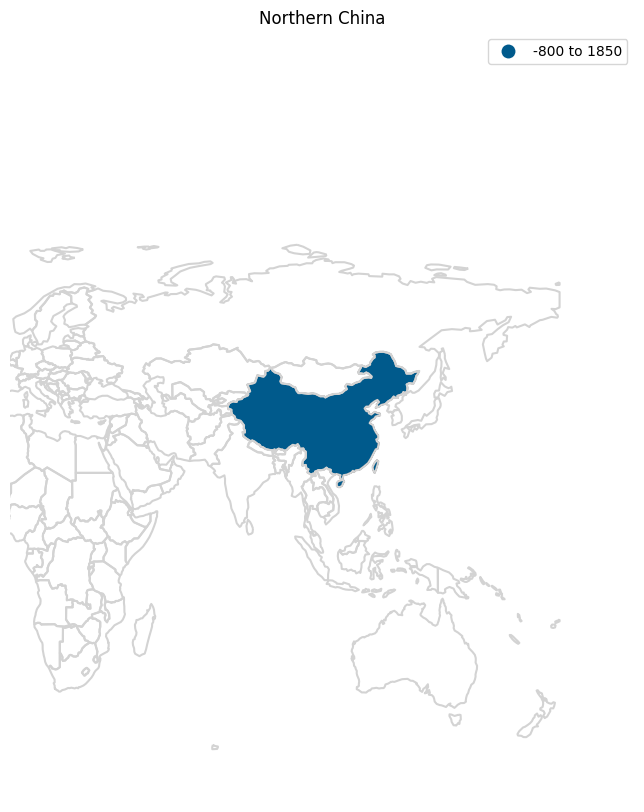

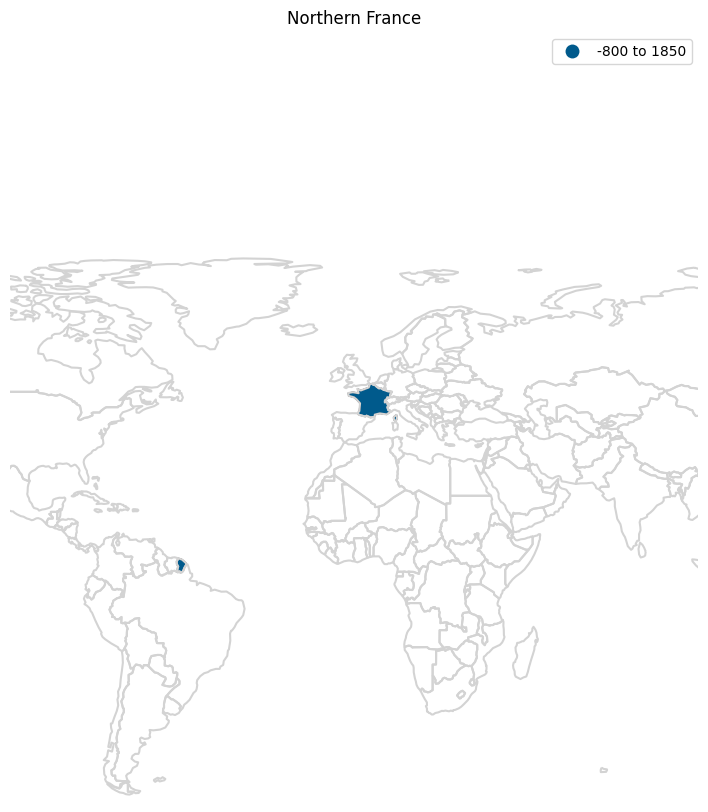

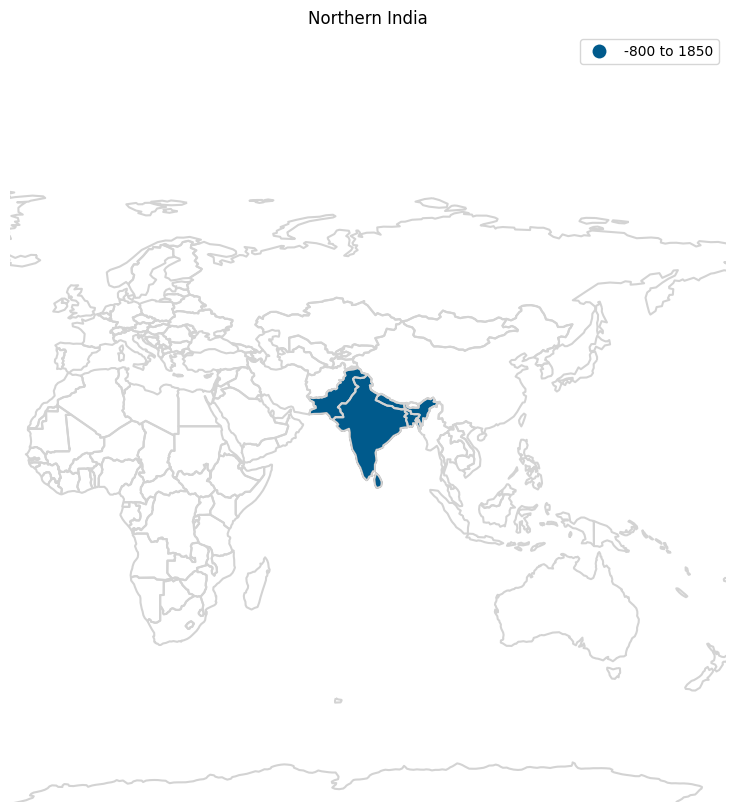

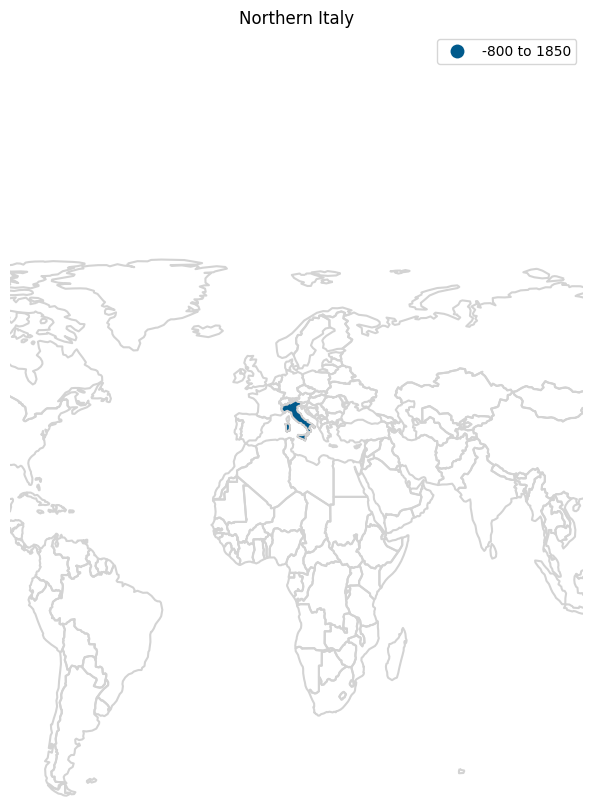

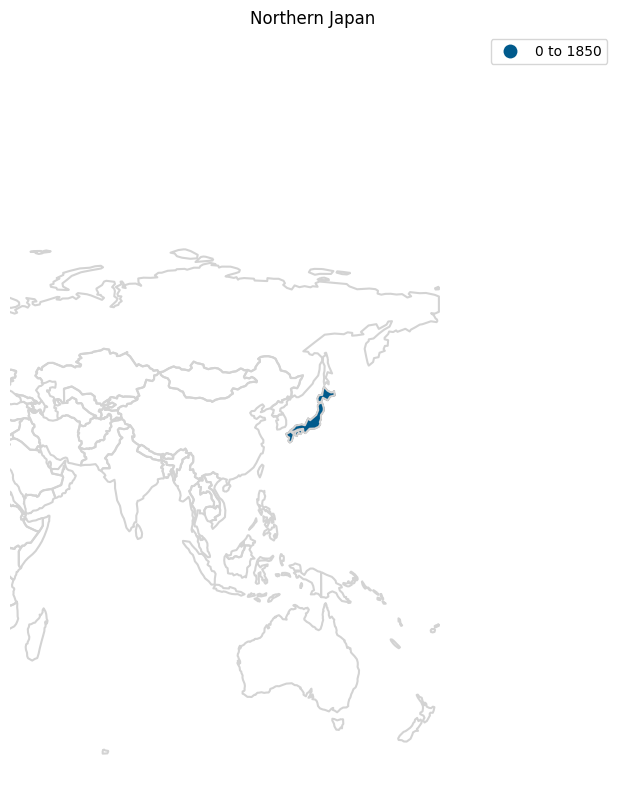

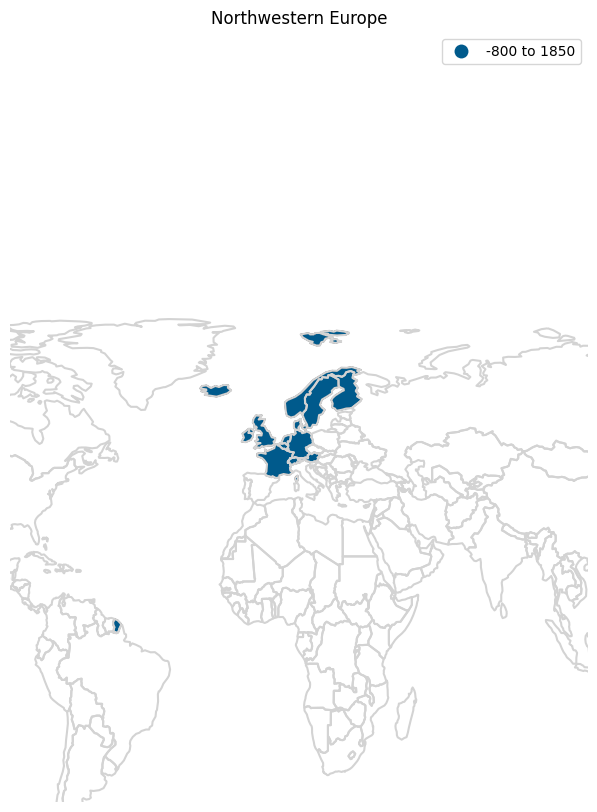

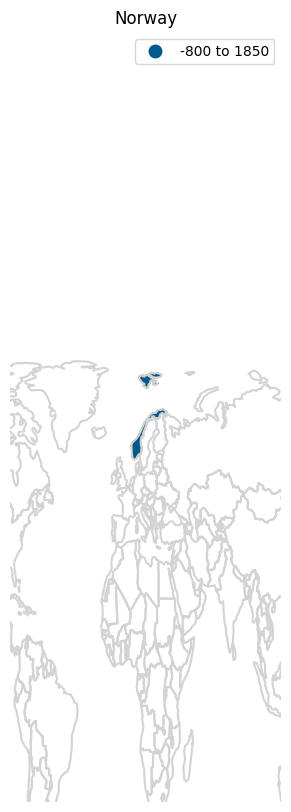

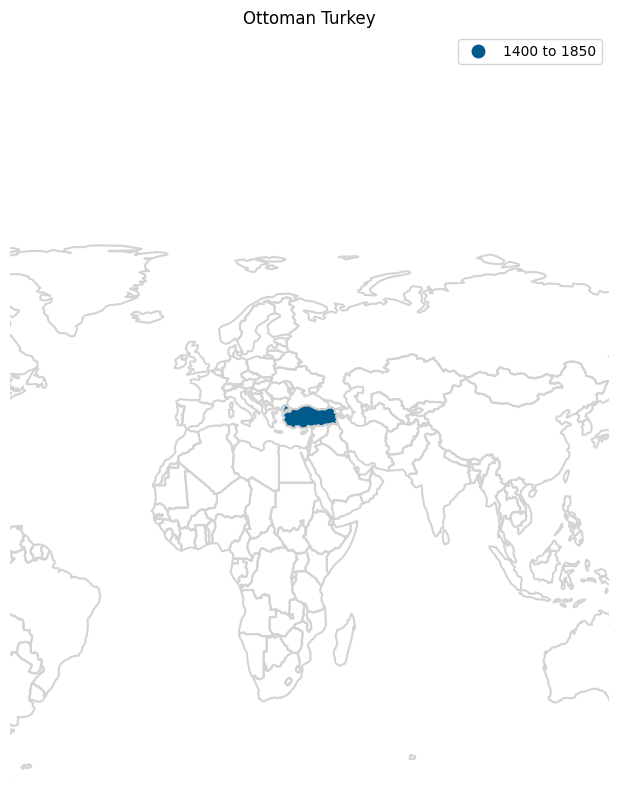

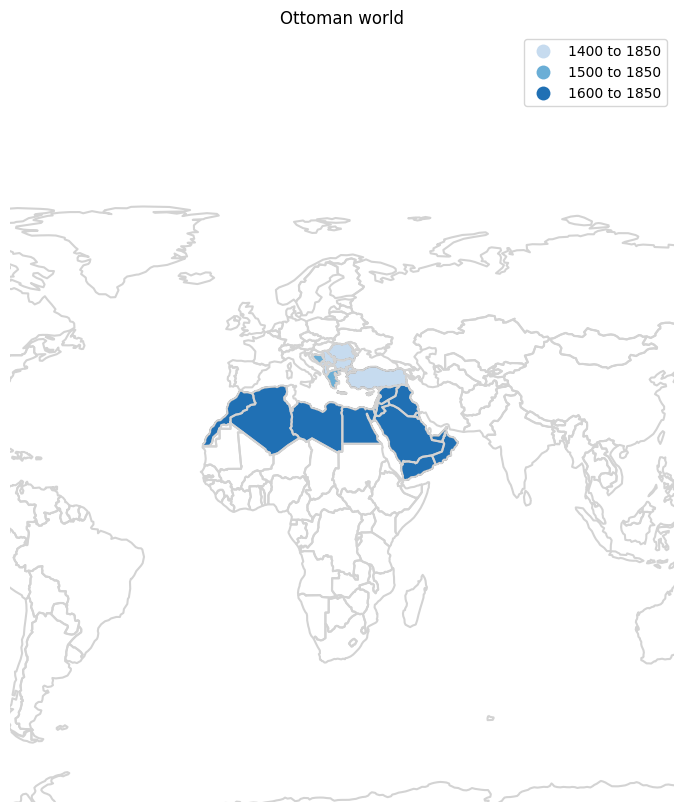

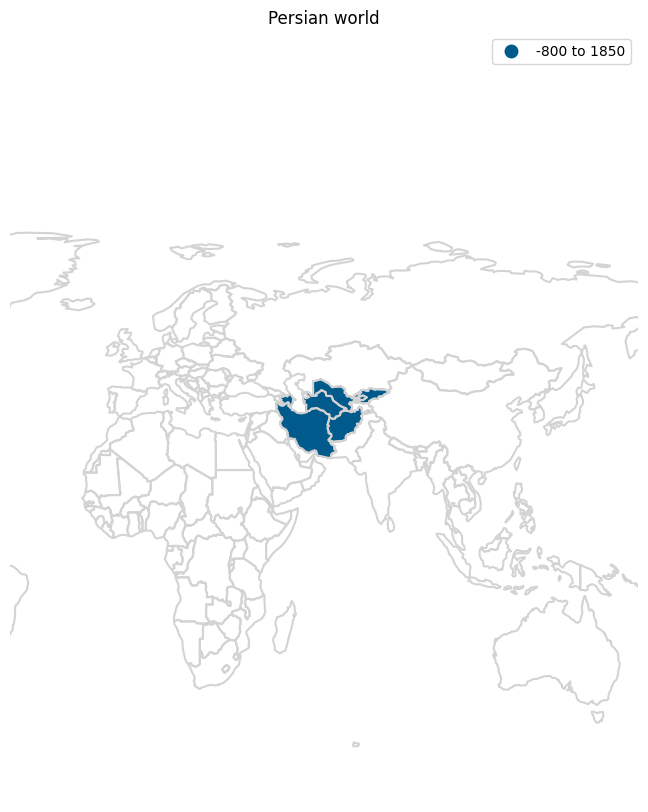

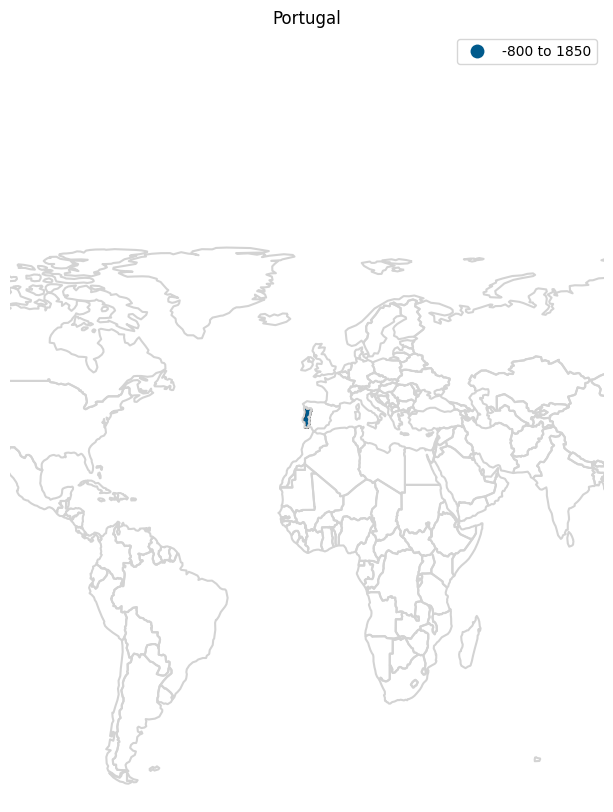

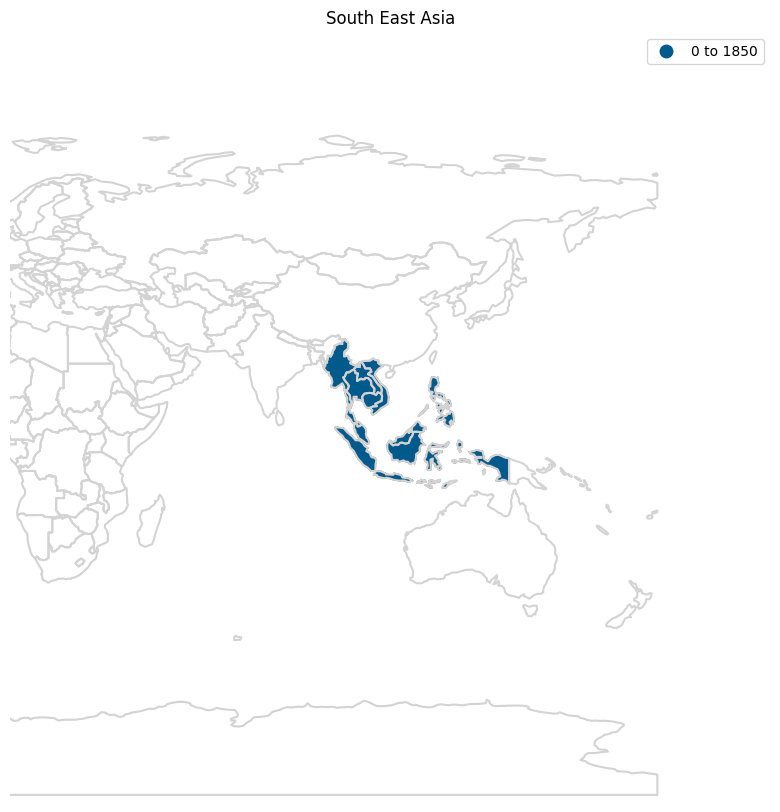

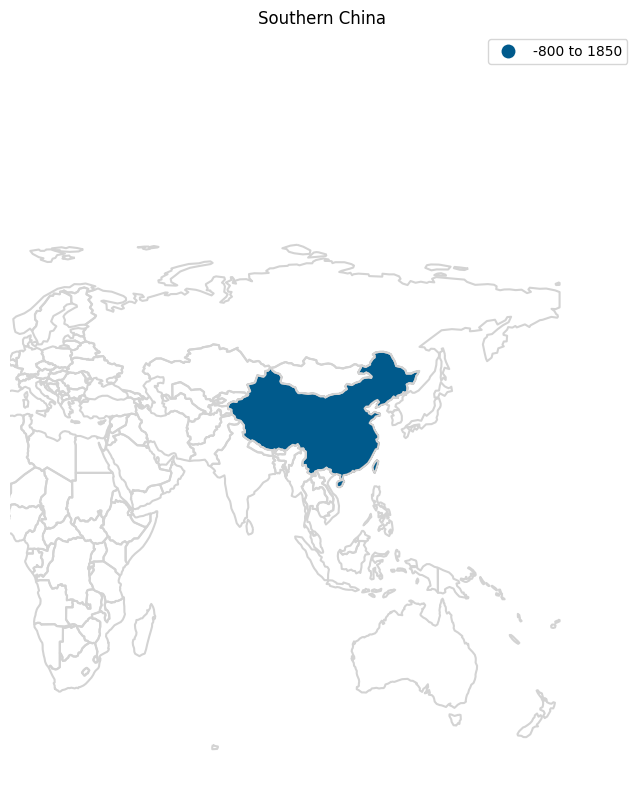

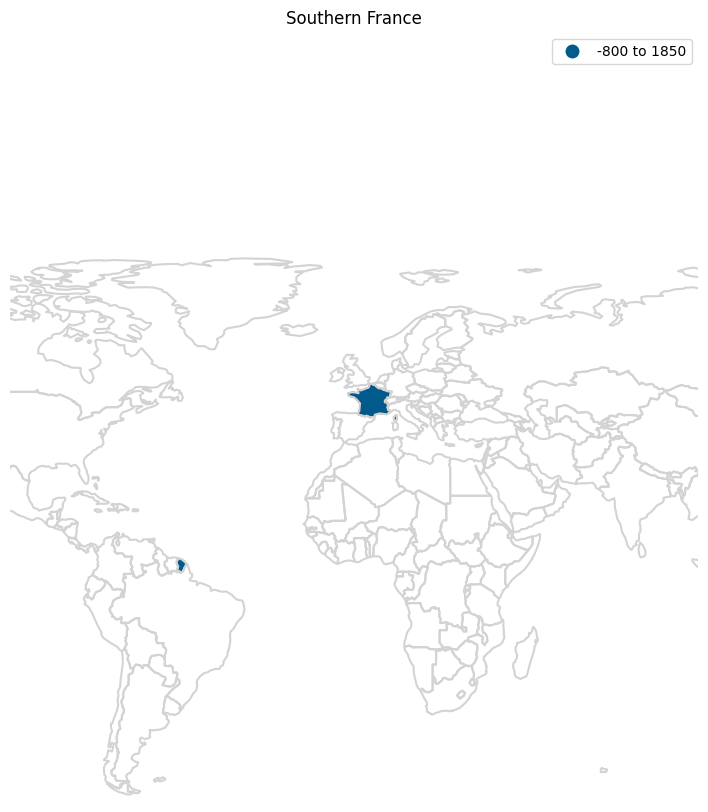

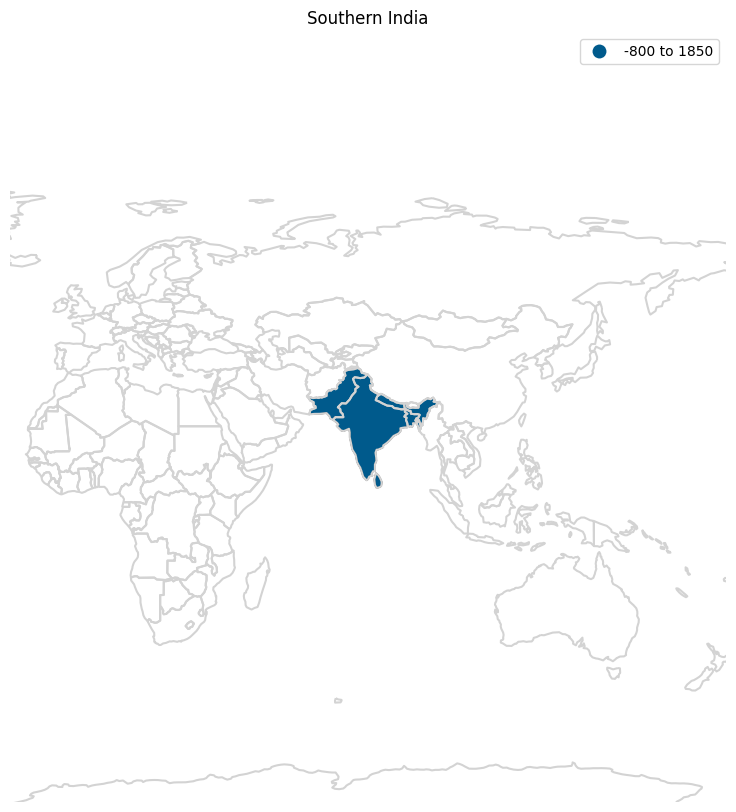

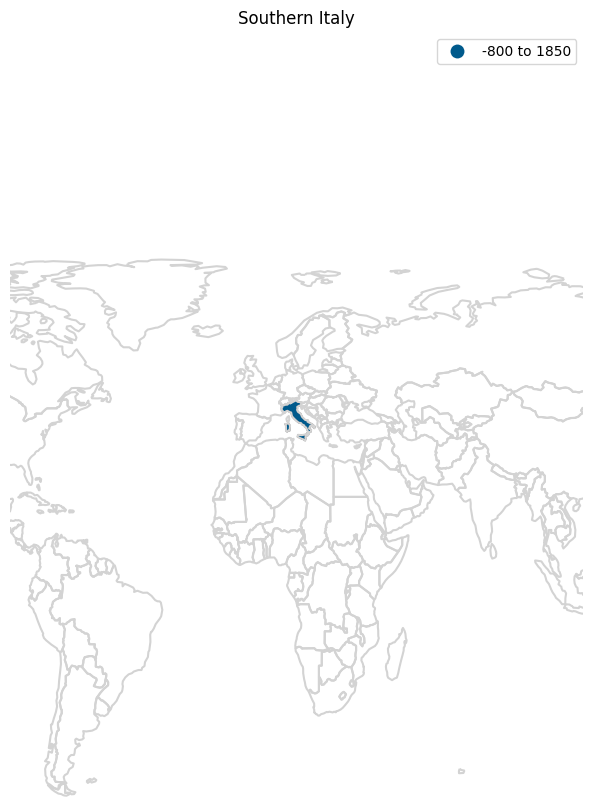

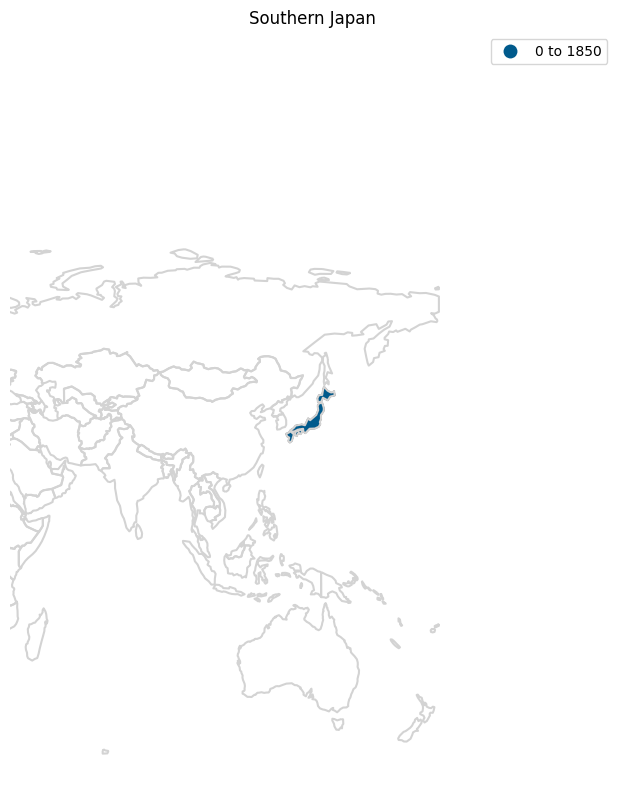

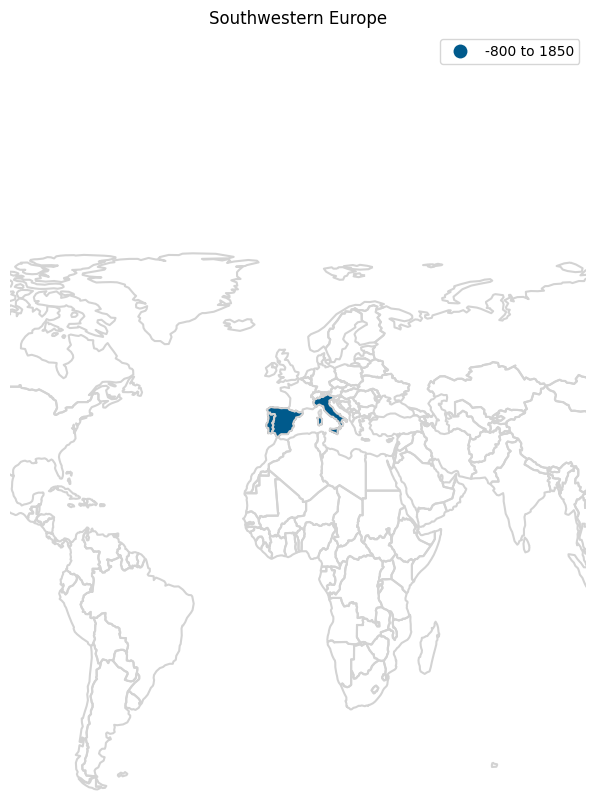

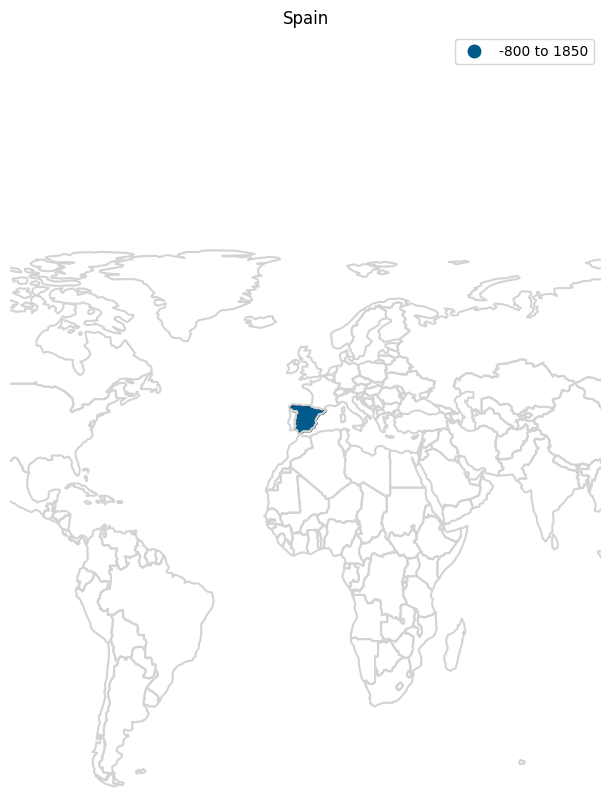

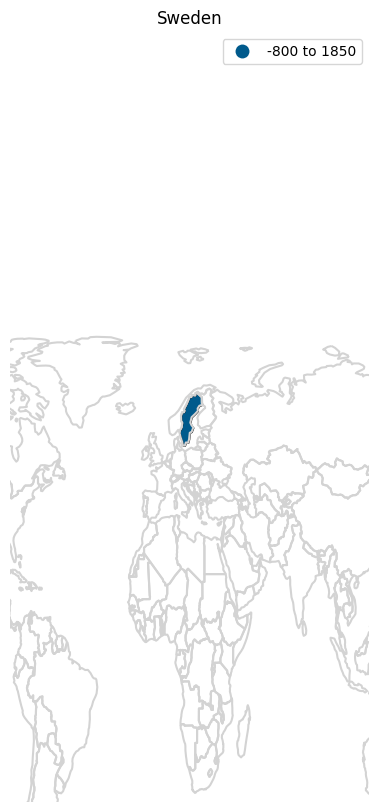

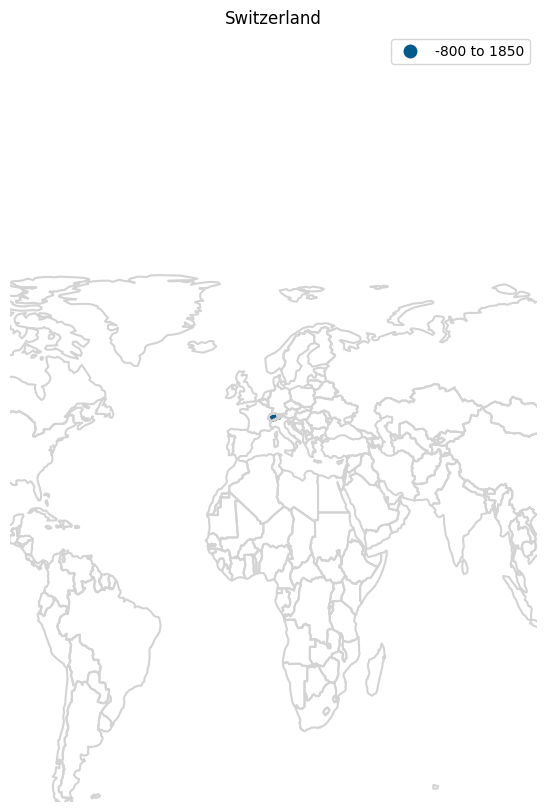

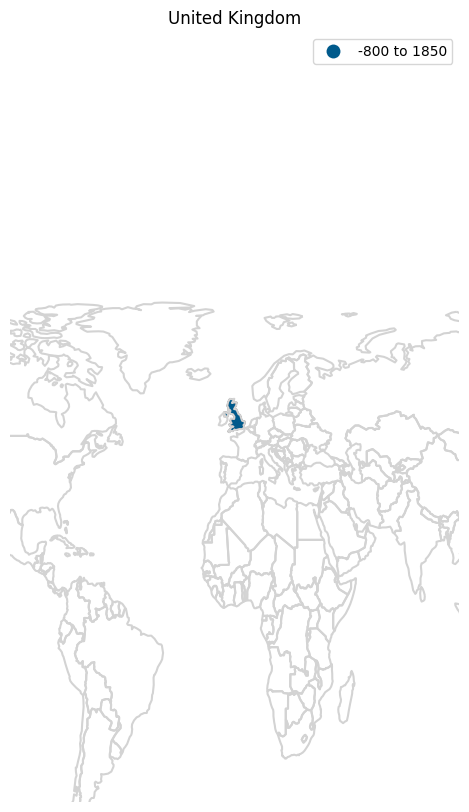

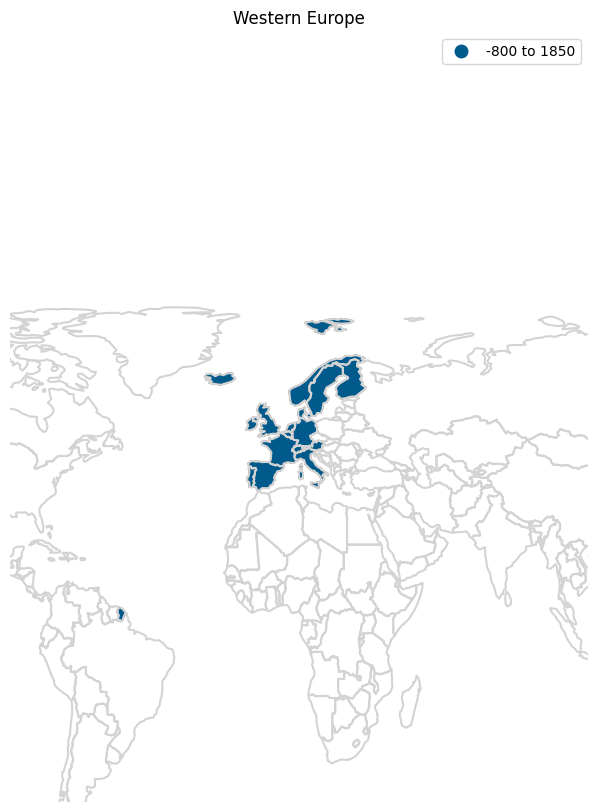

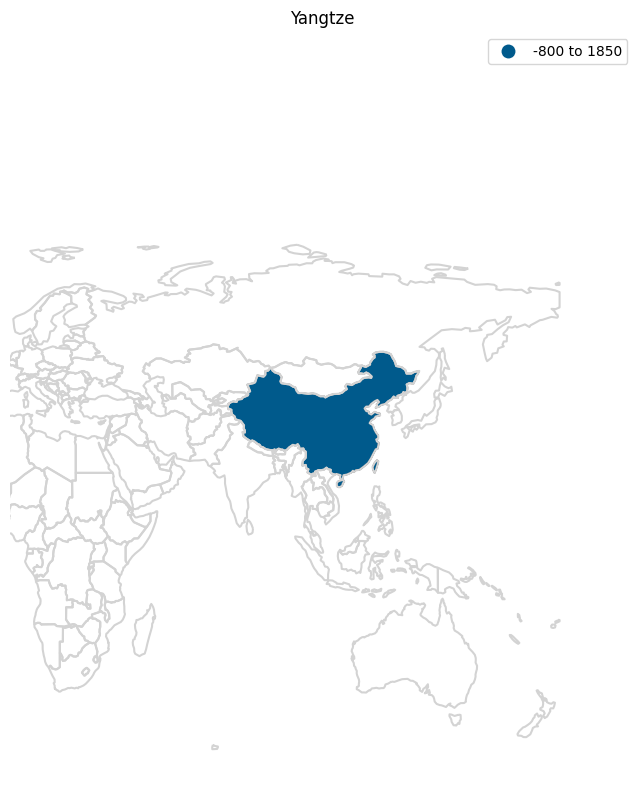

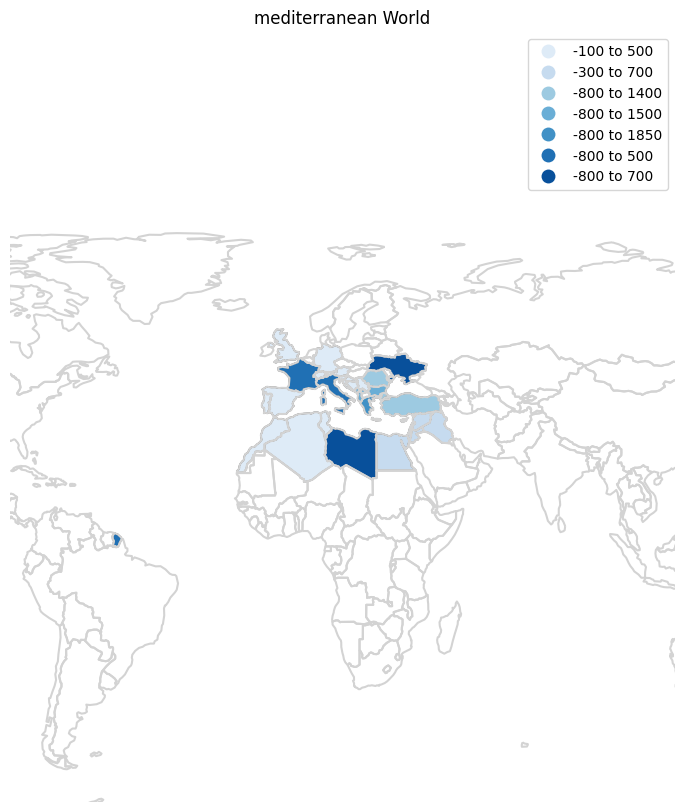

In [136]:
# Iterate through region codes and plot maps
for region_code, region_data in gdf.groupby('region'):


    # Merge with world map to get geometries
    merged_data = pd.merge(world, region_data, on='iso_a3')
    

    # Calculate the centroid of the region's geometries
    region_centroid = merged_data.geometry.unary_union.centroid

    # Plot the map centered around the region's centroid
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(region_code)

    # Set the aspect ratio to be equal for a square plot
    ax.set_aspect('equal')
    
    n=100

    # Set the map extent based on the region's centroid
    ax.set_xlim([region_centroid.x - n, region_centroid.x + n])
    ax.set_ylim([region_centroid.y - n, region_centroid.y + n])

    ax.axis('off')  # Hide the axis
    
    merged_data['unique_date'] = merged_data['min_date'].astype(int).astype(str) + ' to ' +merged_data['max_date'].astype(int).astype(str)
    merged_data = merged_data.sort_values(['min_date', 'max_date'], ascending=(True, True))
    num_unique_pairs = len(set((merged_data['unique_date'])))
    
        


    # Check if there is only one color
    if num_unique_pairs == 1:
        colors = ["#005A8C"]  # Use the specific shade of blue
    else:
        # Automatically choose a gradient of blues
        colors = sns.color_palette("Blues", num_unique_pairs)


    # Create a ListedColormap
    cmap = ListedColormap(colors)

    world.boundary.plot(ax=ax, color='lightgrey')  # Plot the world map boundaries in black
    plot = merged_data.plot(ax=ax, 
                            cmap=cmap, 
                            edgecolor='black', 
                            column='unique_date',
                            cax=False,
                            legend=True)  # Plot the region data with shades of blue
    
    
    
    gdf_filtered = gdf[gdf['region']==region_code]

    

    # Save or display the plot
    plt.savefig(f'map_figures/map_{region_code}.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()  # Display the map


# Close all plots
plt.close('all')